## Zadanie - klasyczna detekcja obiektów

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Celem zadania będzie zaprojektowanie algorytmu detekcji i analizy obiektów,
pozwalającego na zliczenie leków poszczególnych gatunków z podziałem na komórki organizera.

Występuje 7 klas obiektów; od lewej w górnym rzędzie
* `line`\*: czerwono-białe kapsułki
* `keto`: niebieskie tabletki
* `carbon`: duże czarne kapsułki
* `probio`: duże białe kapsułki
* `biox`: małe białe tabletki
* `espu`: małe żółte kapsułki
* `dexi`\*: niebiesko-szare kapsułki (w dolnym rzędzie)

In [197]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic
from skimage.measure import label as skimage_label
from skimage.morphology import remove_small_objects

from typing import List

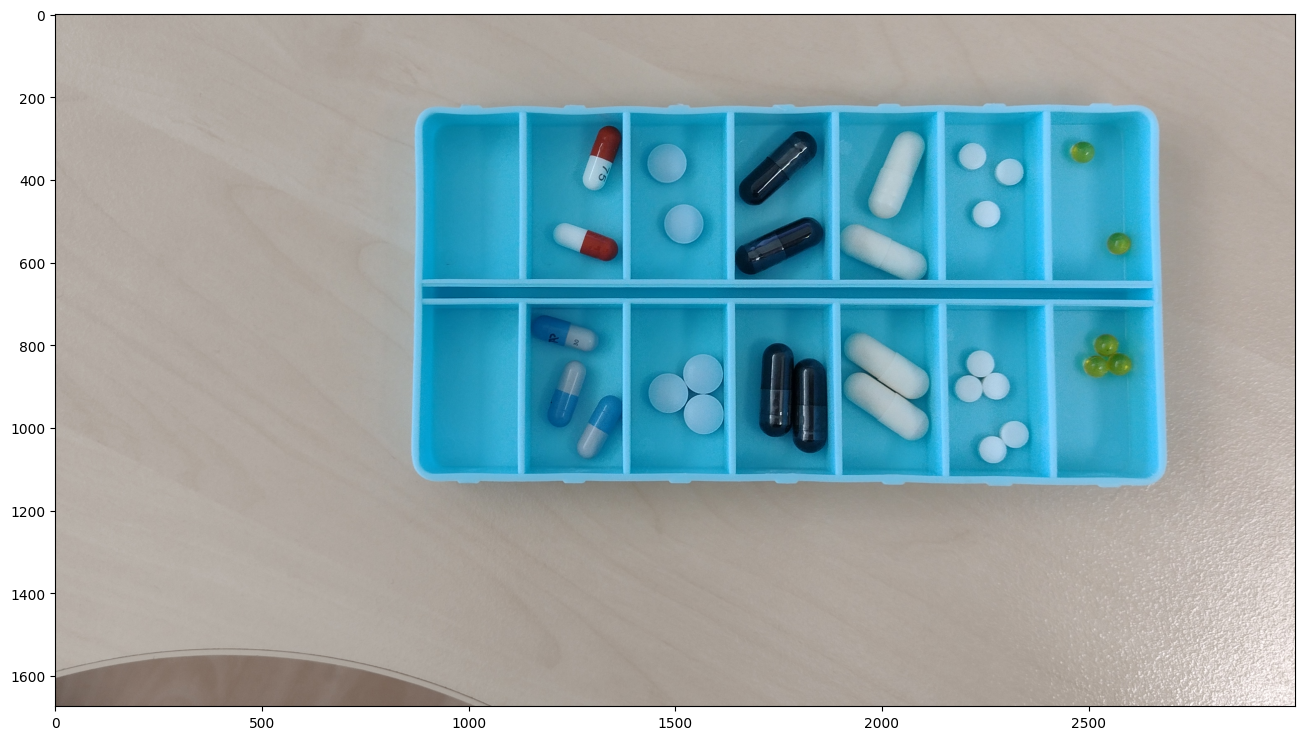

In [2]:
calib = cv2.imread('Lab 5 - dane-20221024/calib.png')
plt.subplots(1, 1, figsize=(16,9))[1].imshow(calib[..., ::-1]);

### Zadanie 1
Wykorzystując narzędzia poznane na poprzednich zajęciach (konwersja przestrzeni barw, detekcja krawędzi, binaryzacja, etc.) oraz [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0), zaproponuj algorytm detekcji obiektów (funkcja `detect_objects`).
Poprawnie działający algorytm powinien zwracać listę konturów lub bounding boksów reprezentujących poszczególne obiekty
(czy nawet dowolnych obiektów zawierających jedno i drugie).

W zależności od przyjętego podejścia, doimplementuj metodę `display_objects`, by wyświetlić rezultaty.

Podpowiedzi:
* zacznij od górnego wiersza, z pominięciem dwukolorowych kapsułek
* w drugiej kolejności podejmij problem stykających się obiektów
* dwukolorowe kapsułki są "dla ambitnych"

In [546]:
class PillDetector():
  
  def _crop_box(self, org_image: np.ndarray, border: int = 25):
    """Detects box and crops an image to it"""
    image = org_image.copy()

    # Otsu threshold on saturation
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[..., 1].astype(np.uint8)
    th, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Binary closing of holes
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (300, 300))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    # Contour finding and cropping (box - maximal area contour)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True))
    x, y, w, h = cv2.boundingRect(contours[0])
    roi = org_image[y + border : y + h - border, x + border : x + w - border]

    return roi

  def _mark_instances(self, org_image: np.ndarray, mask: np.ndarray, open_iters: int = 4):
    """Mark individual instances on the binary mask"""
    image = org_image.copy()

    # Binary opening - shrinking objects
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=open_iters)

    # Prior labelling - for distance thresholding
    _, prior_markers = cv2.connectedComponents(mask.astype(np.uint8))

    # Distance transform + markers - extracting centers of instances
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

    marker_map = np.zeros_like(dist_transform)

    for i in range(1, prior_markers.max() + 1):
      dist_instance = dist_transform * (prior_markers == i)
      instance_map = dist_instance > (0.6 * dist_instance.max())
      marker_map += instance_map

    marker_map = (marker_map > 0).astype(np.uint8)

    # Calculating grow region for objects
    grow_region = cv2.dilate(mask, kernel, iterations=3)
    grow_region = grow_region - marker_map

    # Component marking + watershed
    _, markers = cv2.connectedComponents(marker_map.astype(np.uint8))
    markers += 1
    markers[grow_region == 255] = 0
    markers = cv2.watershed(image, markers)

    # # Plotting
    # fig, axes = plt.subplots(1, 4, figsize=(20, 16))
    # axes[0].imshow(prior_markers)
    # axes[0].axis("off") 
    # axes[1].imshow(dist_transform)
    # axes[1].axis("off")
    # axes[2].imshow(marker_map)
    # axes[2].axis("off")
    # axes[3].imshow(markers)
    # axes[3].axis("off")

    return markers

  def _extract_bbs(self, label_mask: np.ndarray, min_size: int = 0, max_size: int = np.inf):
    """Exracts bbs from labelled mask"""
    objects = []
    
    for i in range(2, label_mask.max() + 1):
      object_mask = (label_mask == i).astype(np.uint8)
      contours, hierarchy = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      if len(contours) > 0:
        contour = contours[0]

        if min_size < cv2.contourArea(contour) < max_size:
          rect = cv2.boundingRect(contour)
          objects.append({"bb": rect, "area": cv2.contourArea(contour)})

    return objects

  def _find_keto_pills(self, org_image: np.ndarray):
    """Detects bbs of keto (blue) pills"""
    image = org_image.copy()

    # Threshold all objects
    image_s = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[..., 1]
    objects = (image_s < 145).astype(np.uint8)

    # Blue color range thresholding - RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.inRange(image, (80, 140, 190), (120, 180, 255))

    # Remove small structures
    mask = remove_small_objects(mask > 0, min_size=400)
    mask = mask.astype(np.uint8) * 255
    
    # Extract components from objects
    _, labelled_objects = cv2.connectedComponents(objects)
    components = np.unique(labelled_objects * (mask > 0))    
    components = components[components != 0]
    mask = np.isin(labelled_objects, components)
    mask = mask.astype(np.uint8) * 255

    markers = self._mark_instances(image, mask, open_iters=0)  
    bbs = self._extract_bbs(markers, min_size=4000, max_size=7000)

    return bbs

  def _find_probio_pills(self, org_image: np.ndarray):
    """Detects bbs of probio (white circular) pills"""
    image = org_image.copy()
    
    # White color range thresholding - RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.inRange(image, (120, 120, 120), (255, 255, 255))
    
    markers = self._mark_instances(image, mask)  
    bbs = self._extract_bbs(markers, min_size=1000, max_size=4000)
    
    return bbs

  def _find_line_pills(self, org_image: np.ndarray):
    """Detects bbs of line (white long) pills"""
    image = org_image.copy()
    
    # White color range thresholding - RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.inRange(image, (120, 120, 120), (255, 255, 255))
    
    markers = self._mark_instances(image, mask)  
    bbs = self._extract_bbs(markers, min_size=4000)
    
    return bbs

  def _find_espu_pills(self, org_image: np.ndarray):
    """Detects bbs of espu (green) pills"""
    image = org_image.copy()

    # Green color range thresholding - a from HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))    

    markers = self._mark_instances(image, mask, open_iters=2)    
    bbs = self._extract_bbs(markers)

    return bbs

  def _find_carbon_pills(self, org_image: np.ndarray):
    """Detects bbs of carbon (black) pills"""
    image = org_image.copy()

    # Black color range thresholding - GRAYSCALE
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.blur(image_gray, (10, 10))
    mask = cv2.inRange(image_gray, 0, 45)

    # Binary closing - remove specular highlights
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=4)

    markers = self._mark_instances(image, mask)  
    bbs = self._extract_bbs(markers, min_size=8000)
    
    return bbs

  def run(self, org_image: np.ndarray, **kwargs) -> List:
    box = self._crop_box(org_image)

    objects = {
      "espu": self._find_espu_pills(box),
      "carbon": self._find_carbon_pills(box),
      "line": self._find_line_pills(box),
      "probio": self._find_probio_pills(box),
      "keto": self._find_keto_pills(box)
    }
    return objects, box

In [517]:
COLORS = [
  (255, 0, 0),
  (0, 255, 0),
  (0, 0, 255),
  (255, 255, 0),
  (255, 0, 255),
  (0, 255, 255),
]

def display_objects(_image: np.ndarray, objects: np.ndarray, _box: np.ndarray) -> None:
  image = _image.copy()
  box = _box.copy()

  COLORMAP = {
    'keto': (0, 0, 255),
    'carbon': (0, 0, 0),
    'probio': (255, 255, 255),
    'biox': (255, 0, 255),
    'espu': (255, 255, 0),
    'line': (255, 0, 0),
    'dexi': (127, 127, 127)
  }

  fig, axes = plt.subplots(1, 2, figsize=(20, 10))

  for name, object_list in objects.items():
    colormap = COLORMAP[name]

    for object in object_list:
      x, y, w, h = object["bb"]
      cv2.rectangle(box, (x, y), (x + w, y + h), colormap, 4)
      cv2.putText(box, f"{name}: {object['area']}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colormap, 2)

  axes[0].imshow(cv2.cvtColor(box, cv2.COLOR_BGR2RGB))
  axes[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  axes[0].axis("off")
  axes[1].axis("off")

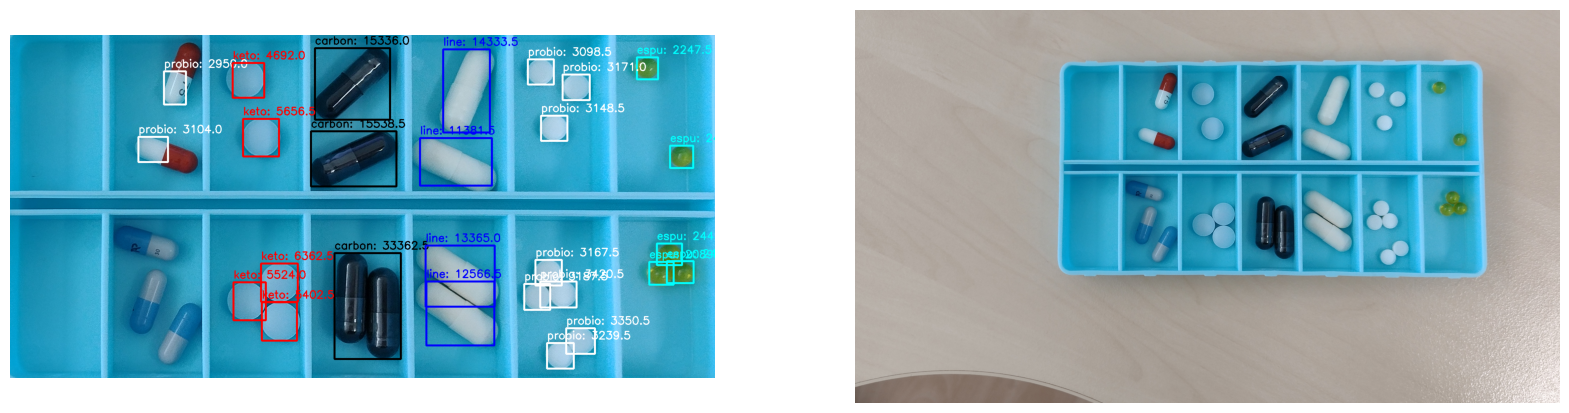

In [547]:
display_objects(calib, *PillDetector().run(calib))

### Zadanie 2
Dodaj do pipeline'u przetwarzania algorytm analizy obiektów, pozwalający na rozróżnienie obiektów poszczególnych klas.
Podejście jest zupełnie dowolne:
możesz zaimplementować go jako osobną procedurę (post-processing uzyskanych konturów) opartą o analizę kształtu i barwy,
możesz próbować zintegrować go z detekcją obiektów.
Obowiązuje tylko jedno zastrzeżenie: algorytm powinien być "klasyczny", tj. bez użycia uczenia maszynowego.

Jakkolwiek zdecydujesz, wyjściem algorytmu powinny być poetykietowane obiekty (kontur/bbox + etykieta).
Dodaj implementację funkcji `display_recognized` do rysowania wykrytych instancji;
skorzystaj z podanej mapy kolorów.

_Pro-tip do podejścia z post-processingiem konturów: zapoznaj się z metodami [zaawansowanego indeksowania macierzy](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing) w numpy, zwłaszcza indeksowaniem za pomocą macierzy binarnej. TL;DR: `obraz[maska]` powoduje odwołanie się tylko do tych pikseli obrazu `obraz`, które odpowiadają położeniem niezerowym pikselom maski._

In [ ]:
COLORMAP = {
  'keto': (0, 0, 255), # RGB
  'carbon': (0, 0, 0),
  'probio': (255, 255, 255),
  'biox': (255, 0, 255),
  'espu': (255, 255, 0),
  'line': (255, 0, 0),
  'dexi': (127, 127, 127)
}

def display_recognized(image:np.ndarray, objects:List) -> None:
  raise NotImplementedError

### Zadanie 3

Przetestuj uzyskany algorytm na obrazach `test1.png`, `test2.png` i `test3.png`.
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

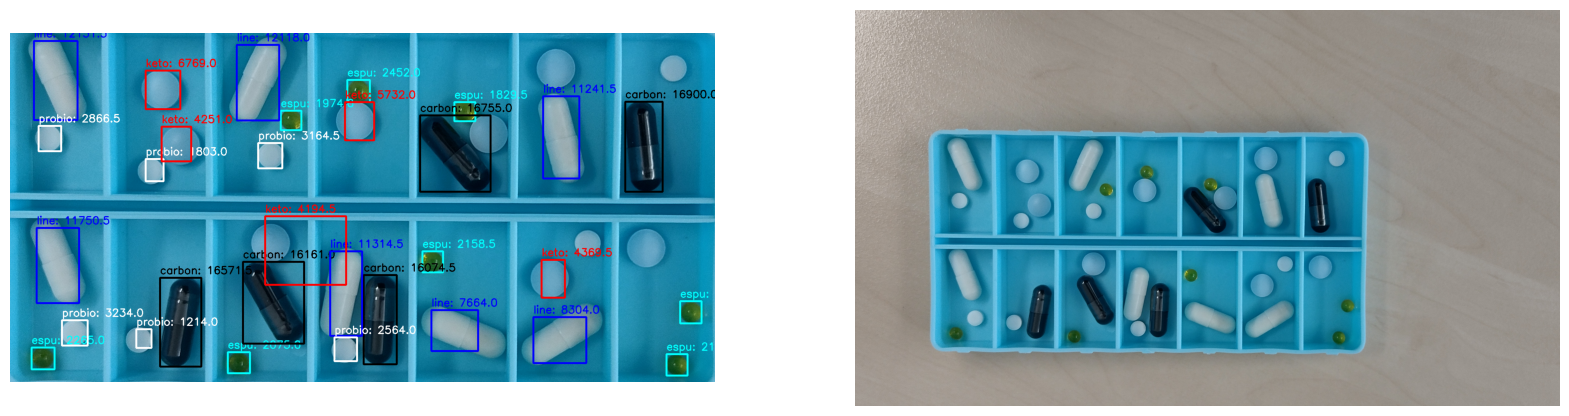

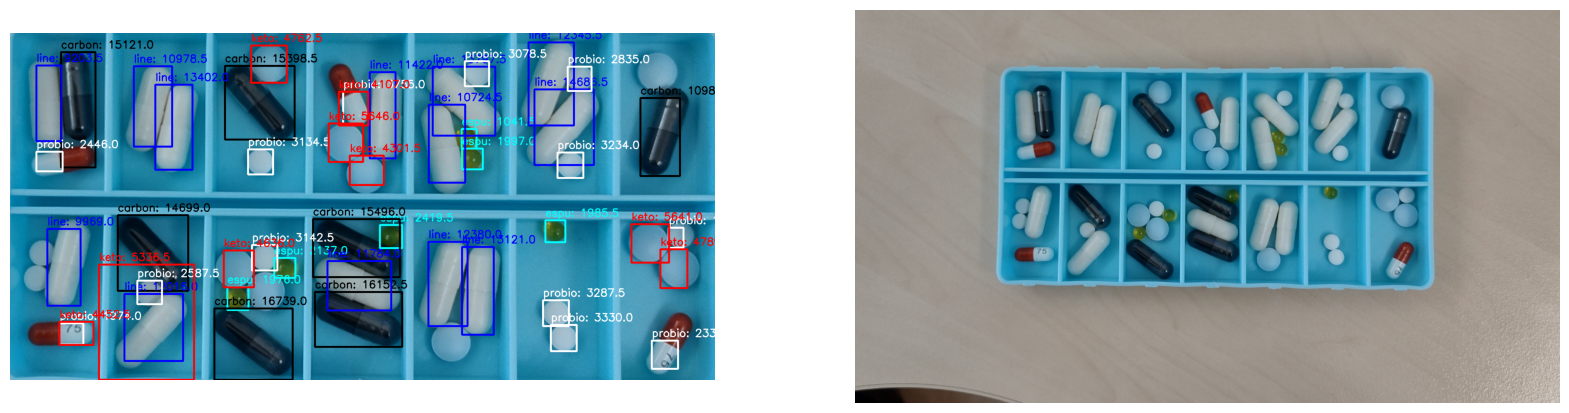

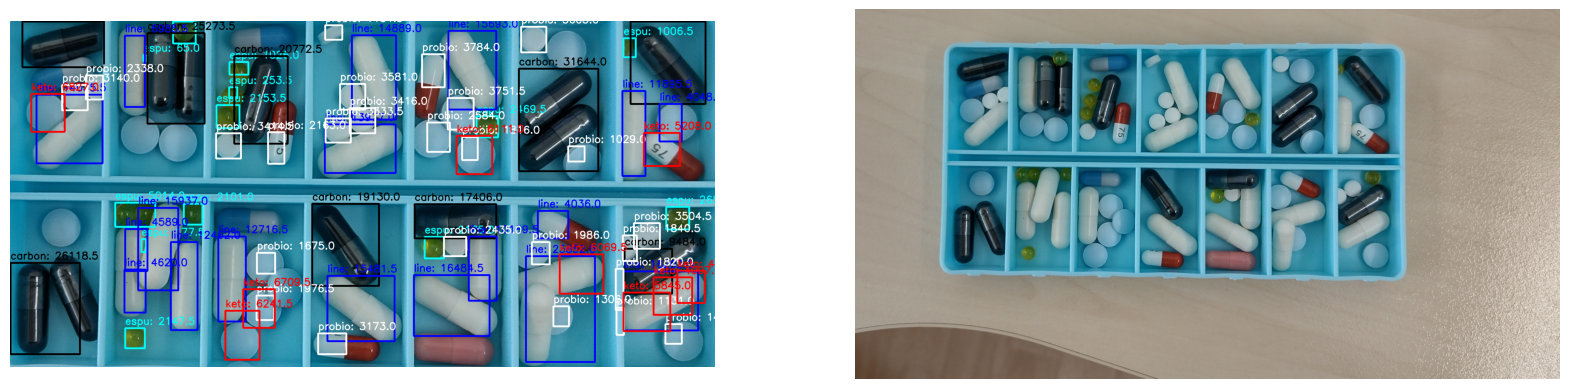

In [548]:
for i in range(3):
    img = cv2.imread(f'Lab 5 - dane-20221024/test{i + 1}.png')
    display_objects(img, *PillDetector().run(img))

In [ ]:
# miejsce na poprawki algorytmu

### Zadanie 4

Wykorzystaj transformację Hougha do wykrycia linii oddzielających poszczególne komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.